In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2

In [4]:
pip install opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
def load_images(path_dir):
    images = []
    for jpg in os.listdir(path_dir):
        image_low_resolution = cv2.imread(f'{path_dir}/{jpg}')
        #image_change_color = cv2.cvtColor(image_high_resolution, cv2.COLOR_BGR2RGB)
        #image_low_resolution = cv2.resize(image_change_color, (200, 200))
        images.append(image_low_resolution)
        
    return np.asarray(images, dtype='object')

In [3]:
normal_img = load_images('C:/Users/vaish/Desktop/MegaProject/Project Glaucoma/normal')

In [4]:
glaucoma_img = load_images('C:/Users/vaish/Desktop/MegaProject/Project Glaucoma/glaucoma')

In [5]:
eye_deseases_img = np.concatenate((glaucoma_img, normal_img)) 

In [6]:
label_eye_deseases = np.concatenate((
    np.repeat(1, glaucoma_img.shape[0]), # Create Label for Glaucoma
    np.repeat(0, normal_img.shape[0]) # Create Label for Normal
))

In [7]:
dict_labels_eye_deseases = {1:'glaucoma', 0:'normal'}

In [8]:
x_train, x_test, y_train, y_test = train_test_split(eye_deseases_img, label_eye_deseases, test_size=0.30,random_state=2184,)

In [9]:
!mkdir model\Train\glaucoma
!mkdir model\Train\normal
!mkdir model\Test\glaucoma
!mkdir model\Test\normal

A subdirectory or file model\Train\glaucoma already exists.
A subdirectory or file model\Train\normal already exists.
A subdirectory or file model\Test\glaucoma already exists.
A subdirectory or file model\Test\normal already exists.


In [10]:
def save_images_directories(x, y, dir_set):
    for i in range(x.shape[0]): 
        plt.imsave(f'{dir_set}/{dict_labels_eye_deseases[y[i]]}/{np.random.randint(1000000)}.jpg', x[i])

save_images_directories(x_train, y_train, 'C:/Users/vaish/Desktop/MegaProject/Project Glaucoma/model/Train')
save_images_directories(x_test, y_test, 'C:/Users/vaish/Desktop/MegaProject/Project Glaucoma/model/Test') 

In [11]:
train_datagen = ImageDataGenerator(rescale = 1/255, horizontal_flip=True,vertical_flip=False)
test_datagen = ImageDataGenerator(rescale = 1/255,horizontal_flip=True,vertical_flip=False,validation_split=0.2)

In [12]:
classes = list(dict_labels_eye_deseases.values())

In [13]:
def results_visualization(history):
    epochs = [i for i in range(20)]
    fig, ax = plt.subplots(1, 2) # Create de plots
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(10, 9)
    
    ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
    ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].plot(epochs, train_loss, 'go-', label='Training loss')
    ax[1].plot(epochs, val_loss, 'ro-', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    
    plt.show()

In [14]:
from tensorflow.keras.callbacks import Callback

def callback_best_model(name_version_model):
    callback_best_model = tf.keras.callbacks.ModelCheckpoint(
                            filepath = f'../results/{name_version_model}',
                            frequency = 'epoch',
                            save_best_only = True,
                            monitor = 'val_accuracy',
                            verbose = 1
                        )
    return callback_best_model

# Create a callback when the model accuracy in training data reached 0.90
class TrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') > 0.90:
            print('The model has reached the accuracy desired (0.90), stop the training!')
            self.model.stop_training = True

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
model_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(200,200,3)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
]
)
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 dense (Dense)               (None, 50)                6000050   
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 6005352 (22.91 MB)
Trainable params: 6005352 (22.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model_base.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
train_generator = train_datagen.flow_from_directory(
    'C:/Users/vaish/Desktop/MegaProject/Project Glaucoma/model/Train',
    target_size=(200,200),
    batch_size=128,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

validation_generator = test_datagen.flow_from_directory(
    'C:/Users/vaish/Desktop/MegaProject/Project Glaucoma/model/Test',
    target_size=(200,200),
    batch_size=126,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'C:/Users/vaish/Desktop/MegaProject/Project Glaucoma/model/Test',
    target_size=(200,200),
    batch_size=128,
    class_mode='categorical',
    color_mode='rgb'
)

Found 10335 images belonging to 2 classes.
Found 886 images belonging to 2 classes.
Found 4433 images belonging to 2 classes.


In [19]:
history = model_base.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[callback_best_model('new_model.h5')]
)

Epoch 1/20
81/81 [==============================] - ETA: 0s - loss: 1.9201 - accuracy: 0.6377
Epoch 1: val_accuracy improved from -inf to 0.72122, saving model to ../results\new_model.h5
81/81 [==============================] - 62s 758ms/step - loss: 1.9201 - accuracy: 0.6377 - val_loss: 0.5031 - val_accuracy: 0.7212
Epoch 2/20
81/81 [==============================] - ETA: 0s - loss: 0.5176 - accuracy: 0.7419
Epoch 2: val_accuracy improved from 0.72122 to 0.79797, saving model to ../results\new_model.h5
81/81 [==============================] - 43s 531ms/step - loss: 0.5176 - accuracy: 0.7419 - val_loss: 0.4187 - val_accuracy: 0.7980
Epoch 3/20
81/81 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.7984
Epoch 3: val_accuracy did not improve from 0.79797
81/81 [==============================] - 44s 540ms/step - loss: 0.4361 - accuracy: 0.7984 - val_loss: 0.5379 - val_accuracy: 0.7133
Epoch 4/20
81/81 [==============================] - ETA: 0s - loss: 0.4104 - accur

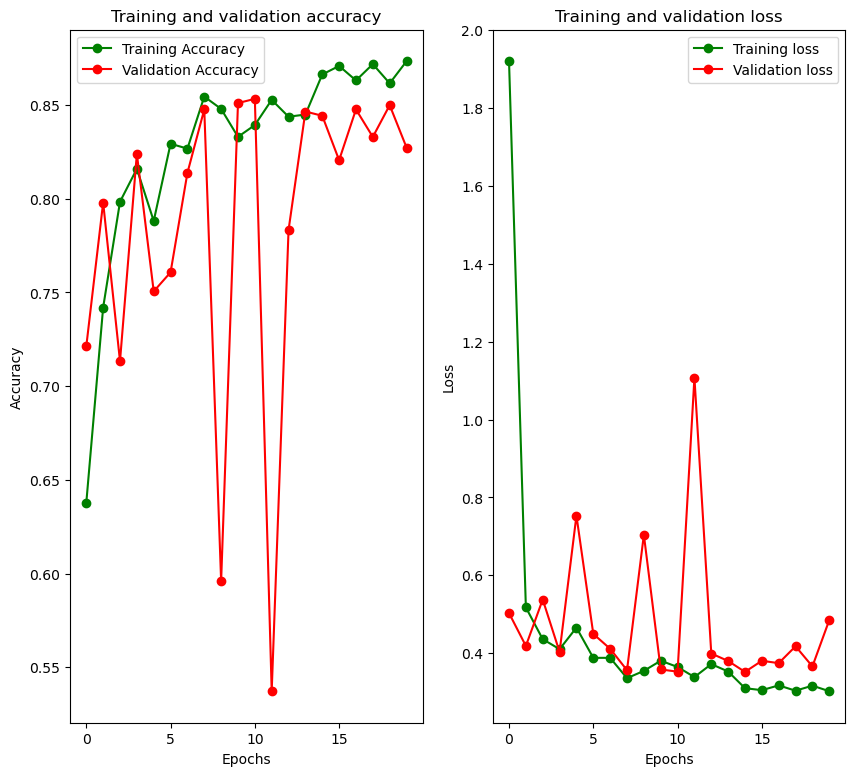

In [20]:
results_visualization(history)

In [29]:
print(f'Accuracy model: {model_base.evaluate(test_generator)[1]}')

35/35 [==============================] - 15s 430ms/step - loss: 0.5066 - accuracy: 0.8202
Accuracy model: 0.8202120661735535


In [30]:
cnn_model = tf.keras.models.Sequential([
    # Input Layer
    tf.keras.layers.Conv2D(64, (2,2), activation='relu', input_shape=(200,200,3)),
    tf.keras.layers.MaxPool2D((2,2)),
    
    # Layer 2
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    # Layer 3
    tf.keras.layers.Conv2D(64, (2,2)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(0.1),
    
    # Layer 4
    tf.keras.layers.Conv2D(128,(2,2), kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.MaxPool2D((2,2)),
    
    # Flatten layer
    tf.keras.layers.Flatten(),
    
    # Output layer
    tf.keras.layers.Dense(2, activation='sigmoid')
])

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 199, 199, 64)      832       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 99, 99, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 98, 98, 64)        16448     
                                                                 
 dropout_2 (Dropout)         (None, 98, 98, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 97, 97, 64)        16448     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                 

In [31]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn_history = cnn_model.fit(
    train_generator,
    epochs = 20,
    callbacks = [callback_best_model('cnn_model.h5')],
    validation_data = validation_generator
)

Epoch 1/20
62/81 [=====================>........] - ETA: 2:07 - loss: 0.6578 - accuracy: 0.6381

In [ ]:
results_visualization(cnn_history)

In [ ]:
print(f'Accuracy model: {cnn_model.evaluate(test_generator)[1]}')

In [38]:
print(f'Accuracy model: {cnn_model.evaluate(test_generator)[0]}')

5/5 [==============================] - 3s 629ms/step - loss: 0.5549 - accuracy: 0.7871
Accuracy model: 0.5549060106277466


In [39]:
cnn_model.save('cnn_3.h5')

In [80]:
model_base.save('model_1.h5')

In [7]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= (200,200,3), pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(2, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 1536)        6144      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 7, 7, 128)         196736    
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 dense_7 (Dense)             (None, 7, 7, 2)           258       
                                                                 
Total params: 10986673 (41.91 MB)
Trainable params: 10